In [1]:
import yfinance as yf

# Download historical stock data (e.g., Apple - AAPL)
stock_data = yf.download('AAPL', start='2010-01-01', end='2024-01-01')
print(stock_data.head())


[*********************100%%**********************]  1 of 1 completed

                Open      High       Low     Close  Adj Close     Volume
Date                                                                    
2010-01-04  7.622500  7.660714  7.585000  7.643214   6.454505  493729600
2010-01-05  7.664286  7.699643  7.616071  7.656429   6.465664  601904800
2010-01-06  7.656429  7.686786  7.526786  7.534643   6.362821  552160000
2010-01-07  7.562500  7.571429  7.466071  7.520714   6.351056  477131200
2010-01-08  7.510714  7.571429  7.466429  7.570714   6.393279  447610800


In [2]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Use the 'Close' price for prediction
close_prices = stock_data['Close'].values
close_prices = close_prices.reshape(-1, 1)

# Scale data to be between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(close_prices)

# Splitting into training and testing sets (80% train, 20% test)
train_size = int(len(scaled_prices) * 0.8)
train_data = scaled_prices[:train_size]
test_data = scaled_prices[train_size:]

# Check the scaled data
print(scaled_prices[:5])


[[0.00410081]
 [0.00416991]
 [0.00353313]
 [0.00346029]
 [0.00372173]]


In [3]:
def create_sequences(data, sequence_length):
    X = []
    y = []
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i, 0])  # Past 'n' days
        y.append(data[i, 0])  # Target: the next day's price
    return np.array(X), np.array(y)

# Set the sequence length (e.g., 60 days)
sequence_length = 60

# Create sequences for training and testing data
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

# Reshape data to fit into LSTM (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


In [4]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# Build the LSTM model
model = Sequential()

# First LSTM layer
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))  # Dropout to prevent overfitting

# Second LSTM layer
model.add(LSTM(units=50))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units=1))  # Output is a single predicted price

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32)


Epoch 1/20


C:\python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0133
Epoch 2/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 7.0033e-04
Epoch 3/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 5.4145e-04
Epoch 4/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 4.6072e-04
Epoch 5/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 5.1591e-04
Epoch 6/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 4.7152e-04
Epoch 7/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 4.4271e-04
Epoch 8/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 5.6748e-04
Epoch 9/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 4.3716e-04
Epoch 10/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 3.6555e-04
Epoch 11/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 3.1454e-04
Epoch 12/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 3.6858e-04
Epoch 13/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 3.8173e-04
Epoch 14/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 3.2412e-04
Epoch 15/20
87/87 ━━━━━━━━━━━━

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


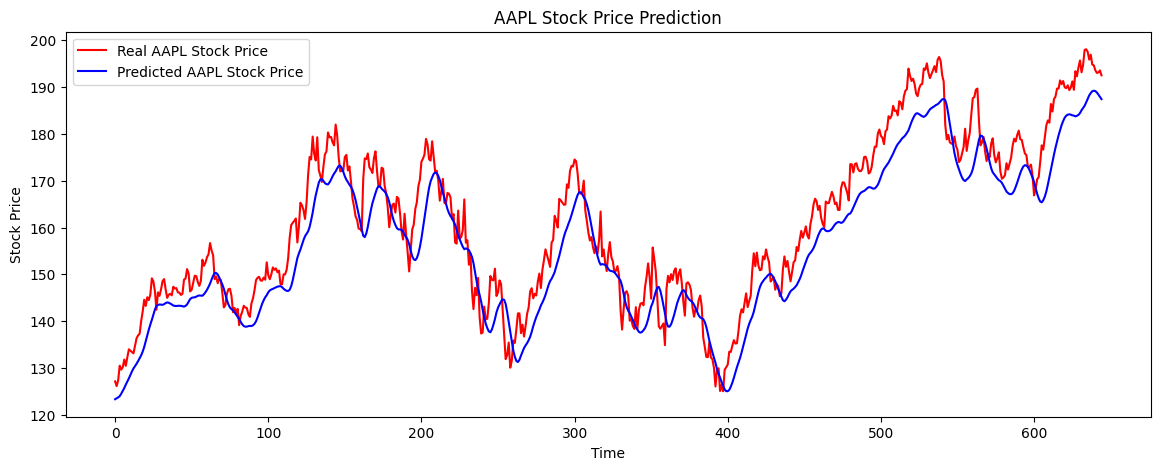

In [5]:
# Predict on the test data
predicted_prices = model.predict(X_test)

# Inverse transform the predictions and the true values to original scale
predicted_prices = scaler.inverse_transform(predicted_prices.reshape(-1, 1))
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.plot(real_prices, color='red', label='Real AAPL Stock Price')
plt.plot(predicted_prices, color='blue', label='Predicted AAPL Stock Price')
plt.title('AAPL Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
